In [1]:
# Download from Google Drive
!gdown --id 18OYbRKPSUcapmGzbxmSfVnz7UMz7OGnO

Downloading...
From: https://drive.google.com/uc?id=18OYbRKPSUcapmGzbxmSfVnz7UMz7OGnO
To: /content/ecg-kaggle.zip
2.72MB [00:00, 42.2MB/s]


In [2]:
!unzip ecg-kaggle.zip

Archive:  ecg-kaggle.zip
   creating: kaggle/
  inflating: __MACOSX/._kaggle       
  inflating: kaggle/Icon             
  inflating: __MACOSX/kaggle/._Icon  
  inflating: kaggle/test.csv         
  inflating: __MACOSX/kaggle/._test.csv  
  inflating: kaggle/train.csv        
  inflating: __MACOSX/kaggle/._train.csv  


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, utils, callbacks, metrics

import cv2
tf.__version__

'2.6.0'

In [4]:
df = pd.read_csv('kaggle/train.csv')
num_classes=5

In [5]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.952899,0.952899,0.653986,0.438406,0.409420,0.403986,0.364130,0.309783,0.268116,0.222826,0.182971,0.146739,0.121377,0.123188,0.110507,0.106884,0.106884,0.094203,0.096014,0.085145,0.081522,0.076087,0.065217,0.057971,0.041667,0.038043,0.019928,0.014493,0.010870,0.000000,0.005435,0.007246,0.019928,0.041667,0.056159,0.079710,0.114130,0.141304,0.172101,0.181159,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.964968,0.646497,0.773885,0.366242,0.181529,0.162420,0.149682,0.146497,0.146497,0.136943,0.127389,0.117834,0.111465,0.105096,0.092357,0.092357,0.082803,0.082803,0.063694,0.060510,0.044586,0.041401,0.035032,0.031847,0.019108,0.009554,0.006369,0.006369,0.000000,0.003185,0.003185,0.009554,0.009554,0.025478,0.035032,0.044586,0.063694,0.082803,0.098726,0.114650,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.977551,1.000000,0.608163,0.393878,0.369388,0.324490,0.275510,0.226531,0.185714,0.144898,0.114286,0.089796,0.093878,0.077551,0.081633,0.055102,0.075510,0.065306,0.061224,0.051020,0.053061,0.044898,0.032653,0.032653,0.030612,0.014286,0.022449,0.008163,0.022449,0.018367,0.034694,0.055102,0.091837,0.120408,0.148980,0.165306,0.179592,0.165306,0.183673,0.169388,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.943878,0.905612,0.706633,0.239796,0.063776,0.150510,0.114796,0.043367,0.015306,0.043367,0.038265,0.048469,0.051020,0.056122,0.066327,0.061224,0.043367,0.053571,0.061224,0.056122,0.058673,0.079082,0.086735,0.089286,0.084184,0.109694,0.094388,0.094388,0.096939,0.119898,0.125000,0.127551,0.112245,0.132653,0.127551,0.114796,0.117347,0.125000,0.122449,0.104592,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.945338,0.848875,0.508039,0.234727,0.131833,0.125402,0.080386,0.086817,0.070740,0.073955,0.054662,0.067524,0.048232,0.028939,0.000000,0.016077,0.016077,0.035370,0.025723,0.035370,0.041801,0.054662,0.048232,0.064309,0.064309,0.073955,0.083601,0.109325,0.099678,0.135048,0.125402,0.151125,0.135048,0.141479,0.144695,0.154341,0.147910,0.170418,0.141479,0.157556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_train, df_val = train_test_split(df, test_size=0.2)

In [7]:
# last column: label
# other columns: ECG signals
x_train = df_train.iloc[:, :-1]
x_train = np.expand_dims(x_train, axis=-1)
y_train = df_train.iloc[:, -1]

x_val = df_val.iloc[:, :-1]
x_val = np.expand_dims(x_val, axis=-1)
y_val = df_val.iloc[:, -1]

y_train = utils.to_categorical(y_train, num_classes=num_classes)
y_val = utils.to_categorical(y_val, num_classes=num_classes)

In [8]:
# (# of data, signal length, channel)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((1167, 187, 1), (1167, 5), (292, 187, 1), (292, 5))

label:  [1. 0. 0. 0. 0.]


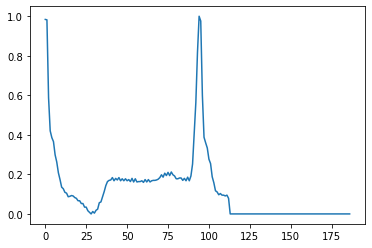

In [9]:
idx = np.random.randint(0, len(x_train))
print('label: ', y_train[idx])
plt.plot(x_train[idx])

In [10]:
np.unique(np.argmax(y_train, axis=-1), return_counts=True), np.unique(np.argmax(y_val, axis=-1), return_counts=True)

((array([0, 1, 2, 3, 4]), array([961,  40,  78,   8,  80])),
 (array([0, 1, 2, 3, 4]), array([247,   5,  20,   2,  18])))

In [11]:
def conv_bn(x, filters, strides=1):
    branch1 = layers.Conv1D(filters, 3, strides=strides, padding='same')(x)
    branch1 = layers.BatchNormalization()(branch1)
    branch1 = layers.ReLU()(branch1)

    branch5 = layers.Conv1D(filters, 1, strides=strides, padding='same')(x)
    branch5 = layers.BatchNormalization()(branch5)
    branch5 = layers.ReLU()(branch5)
    branch5 = layers.Conv1D(filters, 5, strides=strides, padding='same')(branch5)
    branch5 = layers.BatchNormalization()(branch5)
    branch5 = layers.ReLU()(branch5)

    branch10 = layers.Conv1D(filters, 1, strides=strides, padding='same')(x)
    branch10 = layers.BatchNormalization()(branch10)
    branch10 = layers.ReLU()(branch10)
    branch10 = layers.Conv1D(filters, 10, strides=strides, padding='same')(branch10)
    branch10 = layers.BatchNormalization()(branch10)
    branch10 = layers.ReLU()(branch10)    

    branch187 = layers.Conv1D(filters, 1, strides=strides, padding='same')(x)
    branch187 = layers.BatchNormalization()(branch187)
    branch187 = layers.ReLU()(branch187)
    branch187 = layers.Conv1D(filters, 187, strides=strides, padding='same')(branch187)
    branch187 = layers.BatchNormalization()(branch187)
    branch187 = layers.ReLU()(branch187)  

    x = layers.concatenate([branch1, branch5, branch10, branch187],axis=-1)
    
    return x


# def res_block(x, shortcut, filters):
#   shortcut = layers.Conv1D(filters, 1, strides=1, padding='same')(shortcut)
#   shortcut = layers.BatchNormalization()(shortcut)
#   x = layers.add([x, shortcut])
#   return x

def build_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = conv_bn(inputs, 64)
    x = conv_bn(x, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 256)
    x = conv_bn(x, 256)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, x)
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])
    return model

In [12]:
model = build_model(input_shape=x_train.shape[1:])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 187, 64)      128         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 187, 64)      128         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 187, 64)      128         input_1[0][0]                    
______________________________________________________________________________________________

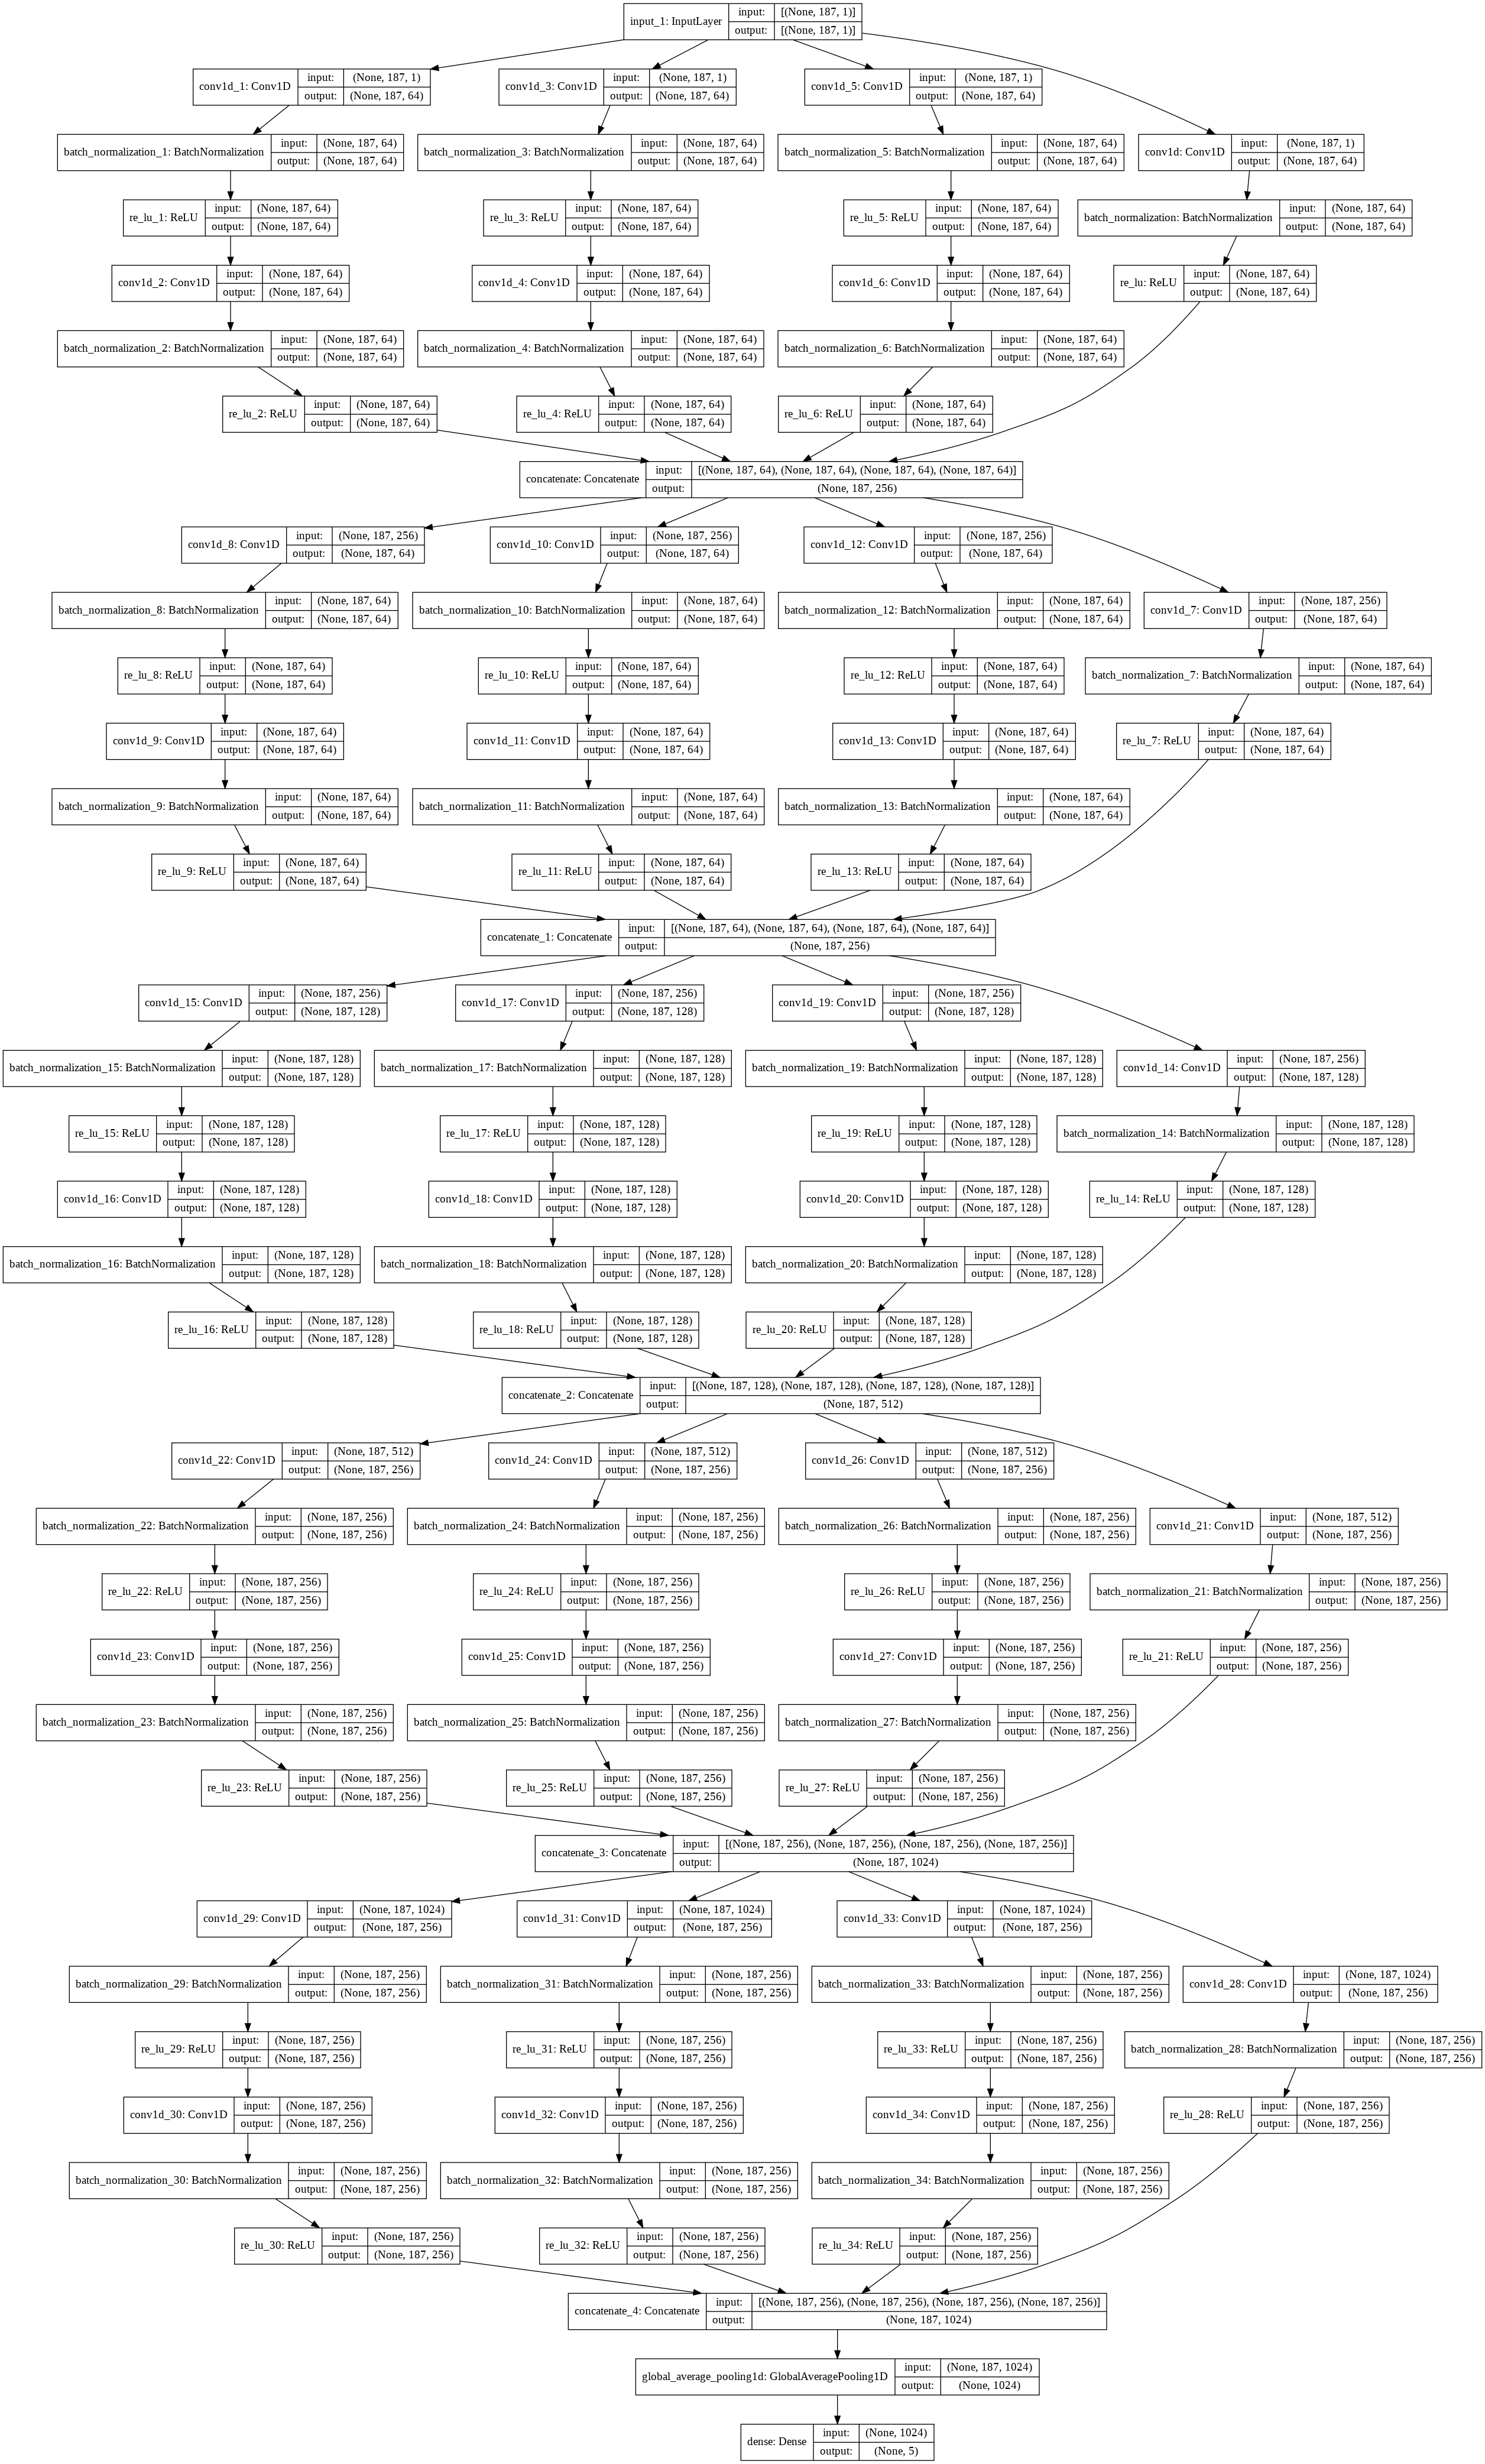

In [13]:
utils.plot_model(model, show_shapes=True)

In [14]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50),
            tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True),
            
            ]

In [15]:
history = model.fit(x_train, y_train, 
                    epochs=1000,
                    callbacks=callback, 
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    class_weight={0: 0.23,
                           1: 6.6,
                           2: 3.43,
                           3: 23.34,
                           4: 2.99}
                    )


Epoch 1/1000
19/19 [==============================] - 67s 1s/step - loss: 1.8327 - accuracy: 0.2742 - val_loss: 1.7194 - val_accuracy: 0.3356
Epoch 2/1000
19/19 [==============================] - 19s 993ms/step - loss: 1.1788 - accuracy: 0.4242 - val_loss: 0.7581 - val_accuracy: 0.8082
Epoch 3/1000
19/19 [==============================] - 19s 987ms/step - loss: 1.0123 - accuracy: 0.4267 - val_loss: 0.9888 - val_accuracy: 0.8459
Epoch 4/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.8036 - accuracy: 0.5356 - val_loss: 1.0119 - val_accuracy: 0.8048
Epoch 5/1000
19/19 [==============================] - 19s 987ms/step - loss: 0.8481 - accuracy: 0.5398 - val_loss: 0.9040 - val_accuracy: 0.7979
Epoch 6/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.6958 - accuracy: 0.5501 - val_loss: 1.8393 - val_accuracy: 0.0514
Epoch 7/1000
19/19 [==============================] - 19s 988ms/step - loss: 0.5889 - accuracy: 0.5458 - val_loss: 1.2739 - val_accur

In [16]:
def cls_report(path):
    model = models.load_model(path)
    pred = np.argmax(model.predict(x_val), axis=-1)
    print(classification_report(np.argmax(y_val, axis=-1), pred))
    print(confusion_matrix(np.argmax(y_val, axis=-1), pred))

In [17]:
cls_report('model.h5')

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       247
           1       0.75      0.60      0.67         5
           2       0.95      0.95      0.95        20
           3       0.17      0.50      0.25         2
           4       0.94      0.94      0.94        18

    accuracy                           0.96       292
   macro avg       0.76      0.79      0.76       292
weighted avg       0.97      0.96      0.96       292

[[239   1   1   5   1]
 [  2   3   0   0   0]
 [  1   0  19   0   0]
 [  1   0   0   1   0]
 [  1   0   0   0  17]]


#### Make prediction

In [18]:
model = models.load_model('model.h5')

x_test = pd.read_csv('kaggle/test.csv')

df_submit = pd.DataFrame([], columns=['Id', 'Category'])
df_submit['Id'] = [f'{i:03d}' for i in range(len(x_test))]
df_submit['Category'] = np.argmax(model.predict(x_test), axis=-1)

In [19]:
df_submit.to_csv('submission.csv', index=None)